# Classifying movie reviews using CNN

In [ ]:
from pathlib import Path
import os
import re
import html
import string

import unicodedata


import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer

from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import models
from keras import layers
from keras import losses
from keras import metrics
from keras import optimizers

import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:

DATA_PATH=Path('./dat/')
DATA_PATH.mkdir(exist_ok=True)
#if not os.path.exists('./dat/aclImdb_v1.tar.gz'):
if not os.path.exists('./dat/aclImdb'):
    !curl -O http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
    !tar -xf aclImdb_v1.tar.gz -C {DATA_PATH}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  21.0M      0  0:00:03  0:00:03 --:--:-- 21.0M


Let's have a look on the raw data:

In [ ]:
import numpy as np
CLASSES = ['neg', 'pos']#, 'unsup']
PATH=Path('./dat/aclImdb/')

def get_texts(path):
    texts,labels = [],[]
    for idx,label in enumerate(CLASSES):
        for fname in (path/label).glob('*.*'):
            #texts.append(fixup(fname.open('r', encoding='utf-8').read()))
            texts.append(fname.open('r', encoding='utf-8').read())
            labels.append(idx)
    #return np.array(texts),np.array(labels)
    return texts, labels

trn_texts,trn_labels = get_texts(PATH/'train')
tst_texts,tst_labels = get_texts(PATH/'test')

In [ ]:
for t in trn_texts[:10]:
  print(t)
  #print('\n')

This was one of the worst Wrestlemania's I've seen. It just didn't stand out at all, really. Card wise, I thought it was going to be pretty good, but every match just seemed to fall short.<br /><br />Chris Benoit vs. MVP One of the better matches. Benoit carried it. I just didn't think MVP was that great, but Benoit saved this match. <br /><br />Kane vs. Khali Wow, these two guys don't mix. Or maybe it's Khali and any other person alive don't mix. Awful match.<br /><br />Melina vs. Ashley I'm not a fan of female wrestling.<br /><br />ECW Originals vs. New Breed I was excited about this match, until I saw it. Really, Really disappointing.<br /><br />Edge vs. CM Punk vs. King Booker vs. Jeff Hardy vs. Matt Hardy vs. Mr. Kennedy vs. Finlay vs. Randy Orton Absolutely the worst MITB match so far. Just a major let down, to many people in the ring at the same time. It just didn't live up.<br /><br />Bobby Lashley vs. Umaga O.K. not extremely impressive, but not the worst of the night.<br /><b

Let's start with the first phase:

# Text preprocessing

In this phase, we apply some operations on the text, to make it in the most usable form for the task at hand. Mainly we clean it up to be more appealing to the problem we try to solve. The input is __text__ and the output is a transformed __text__.

In [ ]:
def remove_special_chars(text):
    re1 = re.compile(r'  +')
    x1 = text.lower().replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
        ' @-@ ', '-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x1))


def remove_non_ascii(text):
    """Remove non-ASCII characters from list of tokenized words"""
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')


def to_lowercase(text):
    return text.lower()



def remove_punctuation(text):
    """Remove punctuation from list of tokenized words"""
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)


def replace_numbers(text):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    return re.sub(r'\d+', '', text)


def remove_whitespaces(text):
    return text.strip()


def remove_stopwords(words, stop_words):
    """
    :param words:
    :type words:
    :param stop_words: from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
    or
    from spacy.lang.en.stop_words import STOP_WORDS
    :type stop_words:
    :return:
    :rtype:
    """
    return [word for word in words if word not in stop_words]


def stem_words(words):
    """Stem words in text"""
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in words]

def lemmatize_words(words):
    """Lemmatize words in text"""

    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]

def lemmatize_verbs(words):
    """Lemmatize verbs in text"""

    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word, pos='v') for word in words])

def text2words(text):
  return word_tokenize(text)

def normalize_text( text):
    text = remove_special_chars(text)
    text = remove_non_ascii(text)
    text = remove_punctuation(text)
    text = to_lowercase(text)
    text = replace_numbers(text)
    words = text2words(text)
    stop_words = stopwords.words('english')
    words = remove_stopwords(words, stop_words)
    #words = stem_words(words)# Either stem or lemmatize
    words = lemmatize_words(words)
    words = lemmatize_verbs(words)

    return ''.join(words)

Now let's apply this on the whole corpus:

In [ ]:
def normalize_corpus(corpus):
  return [normalize_text(t) for t in corpus]


In [ ]:
trn_texts = normalize_corpus(trn_texts)
tst_texts = normalize_corpus(tst_texts)

# Data preparation for LSTM

In this first part we use LSTM model.

Few notes on RNNs:

- RNNs are sequence models. This means we need to encode the sequence of words as sequence of words __indices__, which are obtained from the vocab.
- __Keras tokenizer with Embedding layer__
We will use Keras tokenizer. Index 0 is never given. If we use manual binarization and vocab building, we don't have this issue (which is actually NOT an issue, but intended as we will see below):

This info is important when dealing later with Embedding layer in Keras, where padding with 0's might cause OOV if not considered, so we init that layer with vocab_size + 1 (to account for the missing 0). That layer also has option to mask_zero if needed for LSTM.

Another solution would be to -1 from all binarized values. But this would make padded words same as UNK.

In other words, it's a choice to have two different values for:

A- UNK-->1
B- PAD-->0

In this case, the vocab_sz should increase by 1 (for pad), in case the model needs padding like LSTM.

Or keep them both as 0. In this case, the vocab_sz remains the same as given from the tokenizer.

- RNNs accept variable length inputs by definition. However, since Keras is a static framework (Except in Eager execution mode), it requires the data to have fixed length, hence we need to pad.



In [ ]:
vocab_sz = 10000
tok = Tokenizer(num_words=vocab_sz, oov_token='UNK')
texts = trn_texts + tst_texts
tok.fit_on_texts(texts)

In [ ]:

x_train = tok.texts_to_sequences(trn_texts)
x_test = tok.texts_to_sequences(tst_texts)
y_train = np.asarray(trn_labels).astype('float32')
y_test = np.asarray(tst_labels).astype('float32')

In [ ]:
def get_max_len(texts):
  return max([len(word_tokenize(text)) for text in texts])

def pad_seq(seq, maxlen):
  return np.array(pad_sequences(seq, maxlen=maxlen, padding='post', truncating='post'))

In [ ]:
#maxlen = get_max_len(texts)
maxlen = 100
x_train = pad_seq(x_train, maxlen)
x_test = pad_seq(x_test, maxlen)

In [ ]:
print(x_train.shape)
print(x_test.shape)

(25000, 100)
(25000, 100)


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.4, random_state=42, shuffle=True)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM, Conv1D, MaxPooling1D


embedding_size = 100
# Convolution
kernel_size = 5
filters = 64
pool_size = 4



model = Sequential()
#model.add(Embedding(vocab_sz+1, embedding_size, mask_zero=True, input_length=maxlen)) No masking allowed for Conv1D
model.add(Embedding(vocab_sz+1, embedding_size, input_length=maxlen))
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(MaxPooling1D(pool_size=pool_size))
#model.add(GlobalMaxPooling1D())

model.add(Dense(1, activation='sigmoid'))



model.summary()


Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_30 (Embedding)     (None, 100, 100)          1000100   
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 96, 64)            32064     
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 24, 64)            0         
_________________________________________________________________
dense_29 (Dense)             (None, 24, 1)             65        
Total params: 1,032,229
Trainable params: 1,032,229
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Mount GDrive
from google.colab import drive
drive.mount('/content/gdrive')
gdrive_path = 'gdrive/My Drive/Colab Notebooks/DL NLP Course'

from keras.callbacks import ModelCheckpoint, Callback
model_name = 'basic'
filepath = os.path.join(gdrive_path, 'imdb_lstm_' + model_name + '.h5')
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
model.compile(loss='mse',
              optimizer='adam',
              metrics=['accuracy'])

callbacks_lst = [checkpoint]
# Training
batch_size = 256
epochs = 20
print('Train...')
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_val, y_val),
          #validation_split=0.2,
          callbacks=callbacks_lst)

history_dict = history.history
history_dict.keys()

Train...
Epoch 1/20
59/59 [==============================] - 2s 27ms/step - loss: 0.2339 - accuracy: 0.6020 - val_loss: 0.2156 - val_accuracy: 0.6426
Epoch 2/20
59/59 [==============================] - 1s 25ms/step - loss: 0.2059 - accuracy: 0.6661 - val_loss: 0.2106 - val_accuracy: 0.6523
Epoch 3/20
59/59 [==============================] - 1s 24ms/step - loss: 0.1979 - accuracy: 0.6831 - val_loss: 0.2101 - val_accuracy: 0.6540
Epoch 4/20
59/59 [==============================] - 1s 25ms/step - loss: 0.1931 - accuracy: 0.6919 - val_loss: 0.2112 - val_accuracy: 0.6536
Epoch 5/20
59/59 [==============================] - 1s 24ms/step - loss: 0.1891 - accuracy: 0.7006 - val_loss: 0.2124 - val_accuracy: 0.6517
Epoch 6/20
59/59 [==============================] - 1s 25ms/step - loss: 0.1850 - accuracy: 0.7087 - val_loss: 0.2141 - val_accuracy: 0.6503
Epoch 7/20
59/59 [==============================] - 1s 24ms/step - loss: 0.1804 - accuracy: 0.7178 - val_loss: 0.2166 - val_accuracy: 0.6479
Epoc

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

As you can see, the output of the Conv1D and Maxpool1D is 3D tensor, including the temporal info (pooled over 4). We need to summarize this dimension.

We have 2 options:

1- LSTM: we will see later

2- GlobalMaxPool1D: which takes the max over the temporal and feature dimensions https://stackoverflow.com/questions/43728235/what-is-the-difference-between-keras-maxpooling1d-and-globalmaxpooling1d-functi/43730861

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM, Conv1D, MaxPooling1D, GlobalMaxPooling1D


embedding_size = 100
# Convolution
kernel_size = 5
filters = 64
pool_size = 4



model = Sequential()
#model.add(Embedding(vocab_sz+1, embedding_size, mask_zero=True, input_length=maxlen)) No masking allowed for Conv1D
model.add(Embedding(vocab_sz+1, embedding_size, input_length=maxlen))
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
#model.add(MaxPooling1D(pool_size=pool_size))
model.add(GlobalMaxPooling1D())

model.add(Dense(1, activation='sigmoid'))



model.summary()


Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_31 (Embedding)     (None, 100, 100)          1000100   
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 96, 64)            32064     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 64)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 65        
Total params: 1,032,229
Trainable params: 1,032,229
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
from keras.callbacks import EarlyStopping
callbacks_lst = [EarlyStopping(monitor='val_accuracy', mode='max')]
# Training
batch_size = 256
epochs = 20
print('Train...')
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_val, y_val),
          #validation_split=0.2,
          callbacks=callbacks_lst)

history_dict = history.history
history_dict.keys()

Train...
Epoch 1/20
59/59 [==============================] - 1s 24ms/step - loss: 0.6666 - accuracy: 0.6563 - val_loss: 0.5934 - val_accuracy: 0.7651
Epoch 2/20
59/59 [==============================] - 1s 23ms/step - loss: 0.4613 - accuracy: 0.8116 - val_loss: 0.4042 - val_accuracy: 0.8208
Epoch 3/20
59/59 [==============================] - 1s 23ms/step - loss: 0.2993 - accuracy: 0.8807 - val_loss: 0.3808 - val_accuracy: 0.8316
Epoch 4/20
59/59 [==============================] - 1s 23ms/step - loss: 0.2036 - accuracy: 0.9287 - val_loss: 0.3948 - val_accuracy: 0.8299


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

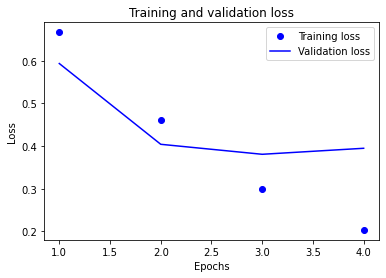

In [ ]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

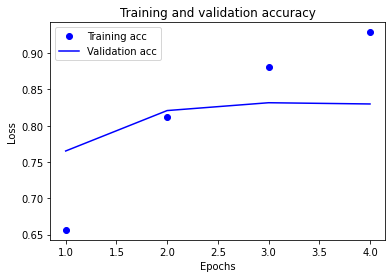

In [ ]:

plt.clf()   # clear figure
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding, Activation
from keras.layers import LSTM, Conv1D, MaxPooling1D, GlobalMaxPooling1D


embedding_size = 128
# Convolution
kernel_size = 5
filters = 64
pool_size = 4


model = Sequential()
#model.add(Embedding(vocab_sz+1, embedding_size, mask_zero=True, input_length=maxlen)) No masking allowed for Conv1D
#model.add(Embedding(vocab_sz+1, embedding_size, mask_zero=True, input_length=maxlen))
model.add(Embedding(vocab_sz+1, embedding_size, input_length=maxlen))
#model.add(Embedding(20000, embedding_size, input_length=100))
model.add(Dropout(0.2))

model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(MaxPooling1D(pool_size=pool_size))

model.add(LSTM(70))
model.add(Dense(1, activation='sigmoid'))



model.summary()


Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_32 (Embedding)     (None, 100, 128)          1280128   
_________________________________________________________________
dropout_15 (Dropout)         (None, 100, 128)          0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 96, 64)            41024     
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 24, 64)            0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 70)                37800     
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 71        
Total params: 1,359,023
Trainable params: 1,359,023
Non-trainable params: 0
___________________________________________

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
from keras.callbacks import EarlyStopping
callbacks_lst = [EarlyStopping(monitor='val_acc', mode='max')]
# Training
batch_size = 256
epochs = 20
print('Train...')
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_val, y_val),
          #validation_split=0.2,
          callbacks=callbacks_lst)

history_dict = history.history
history_dict.keys()

Train...
Epoch 1/20
59/59 [==============================] - 2s 39ms/step - loss: 0.5870 - accuracy: 0.6679 - val_loss: 0.3803 - val_accuracy: 0.8347
Epoch 2/20
59/59 [==============================] - 2s 31ms/step - loss: 0.2795 - accuracy: 0.8894 - val_loss: 0.3352 - val_accuracy: 0.8570
Epoch 3/20
59/59 [==============================] - 2s 31ms/step - loss: 0.1746 - accuracy: 0.9413 - val_loss: 0.3779 - val_accuracy: 0.8499
Epoch 4/20
59/59 [==============================] - 2s 31ms/step - loss: 0.1164 - accuracy: 0.9642 - val_loss: 0.4888 - val_accuracy: 0.8387
Epoch 5/20
59/59 [==============================] - 2s 29ms/step - loss: 0.0773 - accuracy: 0.9771 - val_loss: 0.5110 - val_accuracy: 0.8374
Epoch 6/20
59/59 [==============================] - 2s 29ms/step - loss: 0.0492 - accuracy: 0.9878 - val_loss: 0.5994 - val_accuracy: 0.8331
Epoch 7/20
59/59 [==============================] - 2s 29ms/step - loss: 0.0450 - accuracy: 0.9881 - val_loss: 0.6102 - val_accuracy: 0.8307
Epoc

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Notice how the performance drops with maxlen=1428. Keep in mind that the 1428 is mostly an outlier length. This results in a lot of padded zeros. Introducing a CNN1D over this sparse input produces a lot of useless features. So it's better to focus on smaller length, say 100. But to do this, it needs to be done when padding. It's useless to try to do it using input_length of Embedding, since it doesn't prevent longer sequence from passing.